In [72]:
import itertools
import math
import os
import random
import shutil
from pathlib import Path
from typing import Literal, cast

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.layers.experimental import preprocessing

### Parameters

In [73]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#:~:text=For%20B0%20to%20B7%20base%20models%2C%20the%20input%20shapes%20are%20different.%20Here%20is%20a%20list%20of%20input%20shape%20expected%20for%20each%20model%3A
# IMAGE_SIZE = 224  # MobileNet
# IMAGE_SIZE = 300  # EfficientNetB3
IMAGE_SIZE = 456  # EfficientNetB5
# IMAGE_SIZE = 600  # EfficientNetB7

# BATCH_SIZE = 32
BATCH_SIZE = 16

TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
CHANNELS = 3
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], CHANNELS)

RANDOM_SEED = 123

dataset_input_path, dataset_output_path = "../../data", "../../data"
# dataset_input_path, dataset_output_path = "/kaggle/input/sea-animals-image-dataste", "/kaggle/working/"

dataset_path = dataset_output_path

### Create directories /train, /valid and /test

In [74]:
def directory_is_empty(directory: Path) -> bool:
    if not os.path.isdir(directory):
        return True
    return len(os.listdir(directory)) == 0


def calculate_split_points(images_count: int, train_ratio: float, valid_ratio: float) -> tuple[int, int]:
    train_valid_split_point = math.ceil(images_count * train_ratio)
    valid_test_split_point = train_valid_split_point + math.floor(images_count * valid_ratio)
    return train_valid_split_point, valid_test_split_point


def create_train_test_subdirectories(train_ratio: float = 0.7, validation_ratio: float = 0.1) -> None:
    data_input_path = Path(dataset_input_path)  # Has one subdirectory for each Animal
    if not data_input_path.is_dir():
        raise ValueError(f"Path '{data_input_path}' is not a directory.")
    data_output_path = Path(dataset_output_path)  # Subdirectories /train, /valid and /test
    train_path = data_output_path / "train"
    valid_path = data_output_path / "valid"
    test_path = data_output_path / "test"
    if not directory_is_empty(train_path) and not directory_is_empty(test_path) and not directory_is_empty(valid_path):
        print("/train, /valid and /test directories already exist!")
        return
    for animal_dir in data_input_path.iterdir():
        if not animal_dir.is_dir() or animal_dir.name in ["train", "valid", "test"]:
            continue
        animal_images = [i for i in animal_dir.glob("*") if i.is_file()]
        random.seed(RANDOM_SEED)
        random.shuffle(animal_images)
        train_valid_split_point, valid_test_split_point = calculate_split_points(
            len(animal_images),
            train_ratio,
            validation_ratio,
        )
        train_images = animal_images[:train_valid_split_point]
        valid_images = animal_images[train_valid_split_point:valid_test_split_point]
        test_images = animal_images[valid_test_split_point:]
        train_animal_path = train_path / animal_dir.name
        valid_animal_path = valid_path / animal_dir.name
        test_animal_path = test_path / animal_dir.name
        train_animal_path.mkdir(parents=True, exist_ok=True)
        valid_animal_path.mkdir(parents=True, exist_ok=True)
        test_animal_path.mkdir(parents=True, exist_ok=True)
        for train_image in train_images:
            shutil.copy(str(train_image), str(train_animal_path / train_image.name))
        for valid_image in valid_images:
            shutil.copy(str(valid_image), str(valid_animal_path / valid_image.name))
        for test_image in test_images:
            shutil.copy(str(test_image), str(test_animal_path / test_image.name))
        print(f"{animal_dir.name}:")
        print(f"  - Moved {len(train_images)} images to 'train/{animal_dir.name}'")
        print(f"  - Moved {len(valid_images)} images to 'valid/{animal_dir.name}'")
        print(f"  - Moved {len(test_images)} images to 'test/{animal_dir.name}'")


create_train_test_subdirectories()

/train, /valid and /test directories already exist!


### Placing data into a Dataframe

In [75]:
def get_images_dataframe(directory: Path) -> pd.DataFrame:
    extensions = ["JPG", "jpg", "png", "PNG"]
    images_by_extension = [list(directory.glob(rf"**/*.{extension}")) for extension in extensions]
    filepaths_with_duplicates = [
        image for images_for_extension in images_by_extension for image in images_for_extension
    ]
    filepaths = list(set(filepaths_with_duplicates))

    def get_label_for_path(path: Path) -> str:
        # data/<LABEL>/<fileName>
        path_without_filename = os.path.split(path)[0]
        label = os.path.split(path_without_filename)[1]
        return label

    labels = [get_label_for_path(x) for x in filepaths]

    filepaths = pd.Series(filepaths, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")
    images_df = pd.concat([filepaths, labels], axis=1).sort_values(["Label", "Filepath"])
    return images_df


images_dir = Path(dataset_path)
train_dir = images_dir / "train"
valid_dir = images_dir / "valid"
test_dir = images_dir / "test"

train_df = get_images_dataframe(train_dir)
valid_df = get_images_dataframe(valid_dir)
test_df = get_images_dataframe(test_dir)
images_df = pd.concat([train_df, valid_df, test_df], ignore_index=True).sort_values(["Label", "Filepath"])

assert len(images_df) == 13711
print(images_df)

                                                Filepath  Label
10968  ..\..\data\test\Clams\10004815975_14842bfd9d_o...  Clams
10969  ..\..\data\test\Clams\10057511635_2ea008d261_o...  Clams
10970  ..\..\data\test\Clams\10238296605_8dba4b9c26_o...  Clams
10971  ..\..\data\test\Clams\10488746454_a321ff18b5_b...  Clams
10972   ..\..\data\test\Clams\106439337_17059ddb0c_o.jpg  Clams
...                                                  ...    ...
10963              ..\..\data\valid\Whale\Whale (43).jpg  Whale
10964              ..\..\data\valid\Whale\Whale (44).jpg  Whale
10965               ..\..\data\valid\Whale\Whale (5).jpg  Whale
10966              ..\..\data\valid\Whale\Whale (52).jpg  Whale
10967              ..\..\data\valid\Whale\Whale (77).jpg  Whale

[13711 rows x 2 columns]


### Visualizing images from the dataset

C:\Users\vyjp\AppData\Local\Temp\ipykernel_22076\4113804585.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette="rocket")


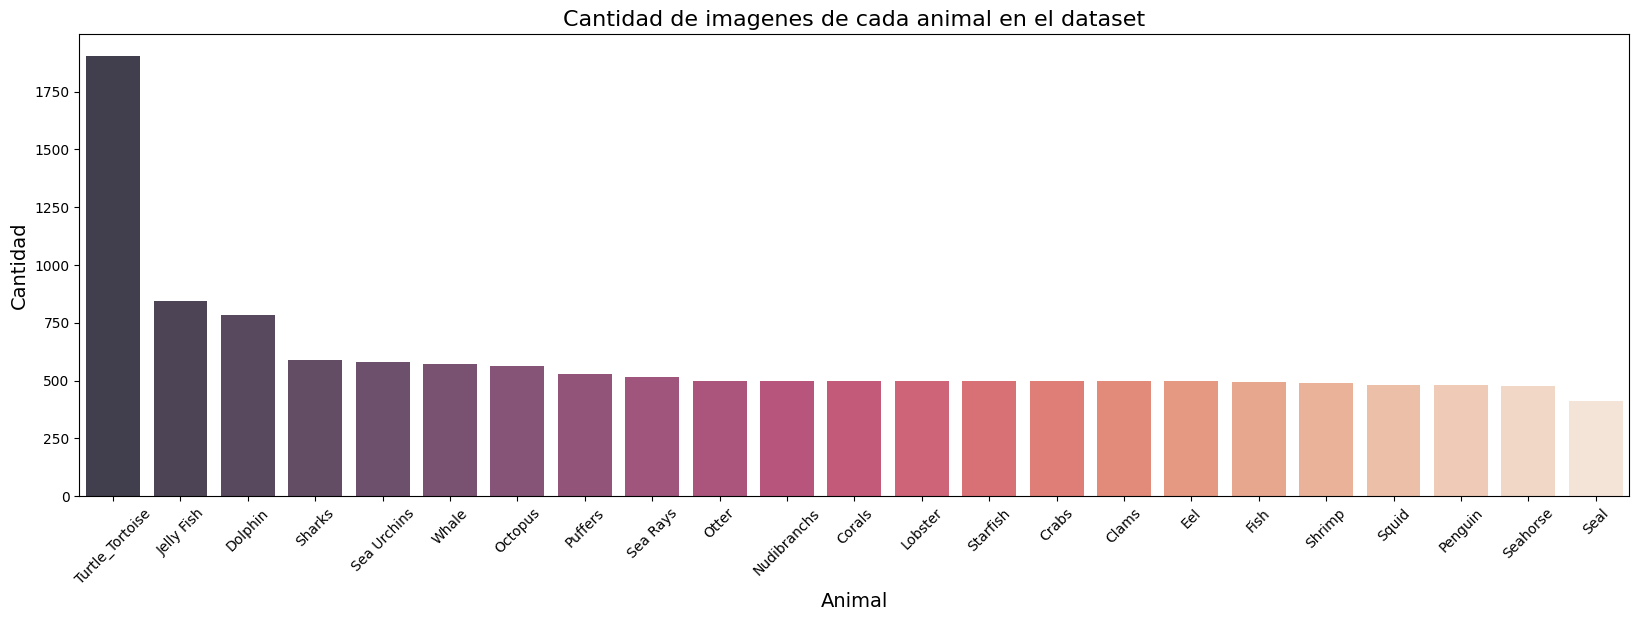

In [76]:
def show_quantities_by_animal() -> None:
    label_counts = images_df["Label"].value_counts()

    fix, ax = plt.subplots(figsize=(20, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette="rocket")
    ax.set_title("Cantidad de imagenes de cada animal en el dataset", fontsize=16)
    ax.set_xlabel("Animal", fontsize=14)
    ax.set_ylabel("Cantidad", fontsize=14)
    ax.tick_params(axis="x", labelrotation=45)
    plt.show()


show_quantities_by_animal()

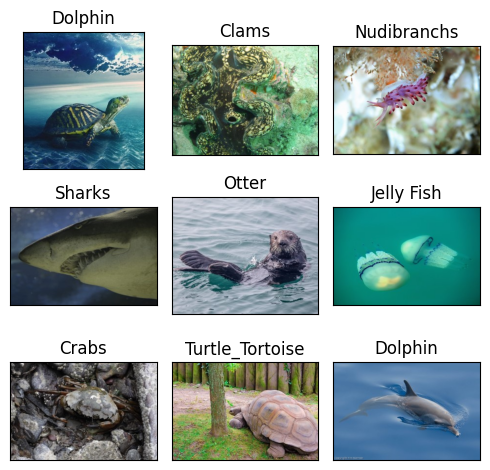

In [77]:
def show_random_examples() -> None:
    rows = 3
    columns = 3
    random_indexes = np.random.randint(0, len(images_df), rows * columns)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(5, 5), subplot_kw={"xticks": [], "yticks": []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(images_df["Filepath"][random_indexes[i]]))
        ax.set_title(images_df["Label"][random_indexes[i]])
    plt.tight_layout()
    plt.show()


show_random_examples()

### Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing.

In [78]:
def read_image_dataset_from_directory(
    path: Path,
    validation_split: float | None = None,
    subset: Literal["training", "validation", "both"] | None = None,
    shuffle: bool = True,
) -> tf.data.Dataset:
    dataset = keras.utils.image_dataset_from_directory(
        directory=path,
        labels="inferred",
        label_mode="int",  # for `sparse_categorical_crossentropy` loss
        # label_mode="categorical",  # for `categorical_crossentropy` loss
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=shuffle,
        seed=RANDOM_SEED,
        validation_split=validation_split,
        subset=subset,
    )
    dataset = cast(tf.data.Dataset, dataset)
    return dataset


def get_train_validate_test_images_dataset() -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    train_dataset = read_image_dataset_from_directory(train_dir)
    validation_dataset = read_image_dataset_from_directory(valid_dir)
    test_dataset = read_image_dataset_from_directory(test_dir, shuffle=False)
    return train_dataset, validation_dataset, test_dataset


train_dataset, validation_dataset, test_dataset = get_train_validate_test_images_dataset()

class_names: list[str] = train_dataset.class_names  # Animal name for each label index
num_classes = len(class_names)
assert num_classes == 23
print(f"Found {num_classes} classes: {class_names}")

Found 9607 files belonging to 23 classes.
Found 1361 files belonging to 23 classes.
Found 2743 files belonging to 23 classes.
Found 23 classes: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


### Training the model

In [79]:
def use_mobilenet_pretrained_model() -> keras.Model:
    mobile_model = keras.applications.MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights="imagenet",
        # pooling="avg",
        # pooling="max",
        pooling=None,
    )
    mobile_model.trainable = False

    model = keras.Sequential()
    model.add(mobile_model)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.45))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.45))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


def use_efficientnet_pretrained_model() -> keras.Model:
    # efficientnet_model = keras.applications.EfficientNetB3(
    efficientnet_model = keras.applications.EfficientNetB5(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights="imagenet",
        # pooling="avg",
        pooling="max",
        # pooling=None,
    )
    efficientnet_model.trainable = False

    data_augmentation = keras.Sequential(
        [
            keras.layers.RandomFlip("horizontal", input_shape=INPUT_SHAPE),
            keras.layers.RandomRotation(0.1),
            keras.layers.RandomZoom(0.1),
            # fill_mode="nearest",
        ]
    )
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = data_augmentation(inputs)
    x = efficientnet_model(x, training=False)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    # optimizer = keras.optimizers.Adamax()
    optimizer = keras.optimizers.Adam()
    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
    )
    return model

    # model = keras.Sequential()
    # model.add(efficientnet_model)
    # model.add(keras.layers.Flatten())
    # model.add(keras.layers.Dense(128, activation="relu"))
    # model.add(keras.layers.Dropout(0.45))
    # model.add(keras.layers.Dense(256, activation="relu"))
    # model.add(keras.layers.Dropout(0.45))
    # model.add(keras.layers.Dense(num_classes, activation="softmax"))
    # return model


def use_custom_model() -> keras.Model:
    model = keras.Sequential(
        [
            keras.layers.Input(shape=INPUT_SHAPE),
            keras.layers.Conv2D(32, (3, 3), activation="relu"),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation="relu"),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(128, (3, 3), activation="relu"),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


model = use_efficientnet_pretrained_model()
model.summary()

c:\Projs\MY_CustomProjects\UTN\ProcesamientoImagenesSeniales\cnn-animales-marinos\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,778,766 (109.78 MB)

 Trainable params: 265,239 (1.01 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [80]:
SAVED_MODEL_PATH = "animals_eff.EfficientNetB5.weights.h5"


def show_training_history_plot(history: keras.callbacks.History) -> None:
    print(history.history.keys())

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    EPOCHS = range(len(accuracy))
    plt.plot(EPOCHS, accuracy, "b", label="Training accuracy")
    plt.plot(EPOCHS, val_accuracy, "r", label="Validation accuracy")

    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(EPOCHS, loss, "b", label="Training loss")
    plt.plot(EPOCHS, val_loss, "r", label="Validation loss")

    plt.title("Training and validation loss")
    plt.legend()
    plt.show()


def train_model():
    EPOCHS = 15
    callbacks = []
    history: keras.callbacks.History = model.fit(
        # train_images,
        train_dataset,
        epochs=EPOCHS,
        verbose=1,
        # steps_per_epoch=len(train_images),
        validation_data=validation_dataset,
        # validation_steps=len(validation_images),
        callbacks=callbacks,
        # shuffle=False,
    )
    model.save_weights(SAVED_MODEL_PATH)
    show_training_history_plot(history)


def load_model_weights_from_file() -> None:
    model_file = Path(SAVED_MODEL_PATH)
    model.load_weights(model_file)


model_file_exists = Path(SAVED_MODEL_PATH).exists()
if model_file_exists:
    print("File with model weights exists, so no need to train the model!")
    load_model_weights_from_file()
else:
    print("File with model weights doesn't exist, so we have to train it")
    train_model()

File with model weights exists, so no need to train the model!


c:\Projs\MY_CustomProjects\UTN\ProcesamientoImagenesSeniales\cnn-animales-marinos\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Model Evaluation

In [24]:
def evaluate_model() -> None:
    loss, accuracy = model.evaluate(test_dataset, verbose=1)
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))


# evaluate_model()

### Predict the Test Images

In [25]:
test_dataset_predictions = model.predict(test_dataset)

172/172 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step


In [87]:
predicted_labels_indices: list[int] = np.argmax(test_dataset_predictions, axis=1)
predicted_labels = [class_names[li] for li in predicted_labels_indices]
prediction_confidences: list[float] = np.max(test_dataset_predictions, axis=1)
filepaths: list[str] = test_dataset.file_paths

filepaths_series = pd.Series(filepaths, name="Filepath")
predicted_labels_series = pd.Series(predicted_labels, name="PredictedLabel")
prediction_confidences_series = pd.Series(prediction_confidences, name="PredictionConfidence")
prediction_results_df = pd.concat([filepaths_series, predicted_labels_series, prediction_confidences_series], axis=1)
prediction_results_df = pd.merge(
    test_df,
    prediction_results_df,
    how="inner",
    left_on="Filepath",
    right_on="Filepath",
).rename(columns={"Label": "RealLabel"})

total_predictions_count = len(prediction_results_df)
correct_predictions_count = len(
    prediction_results_df[prediction_results_df["PredictedLabel"] == prediction_results_df["RealLabel"]]
)
print(
    f"# of correct predictions: {correct_predictions_count}/{total_predictions_count} ({correct_predictions_count * 100.0 / total_predictions_count:.1f}%)"
)

# of correct predictions: 2308/2743 (84.1%)


### Show plot with sample predictions

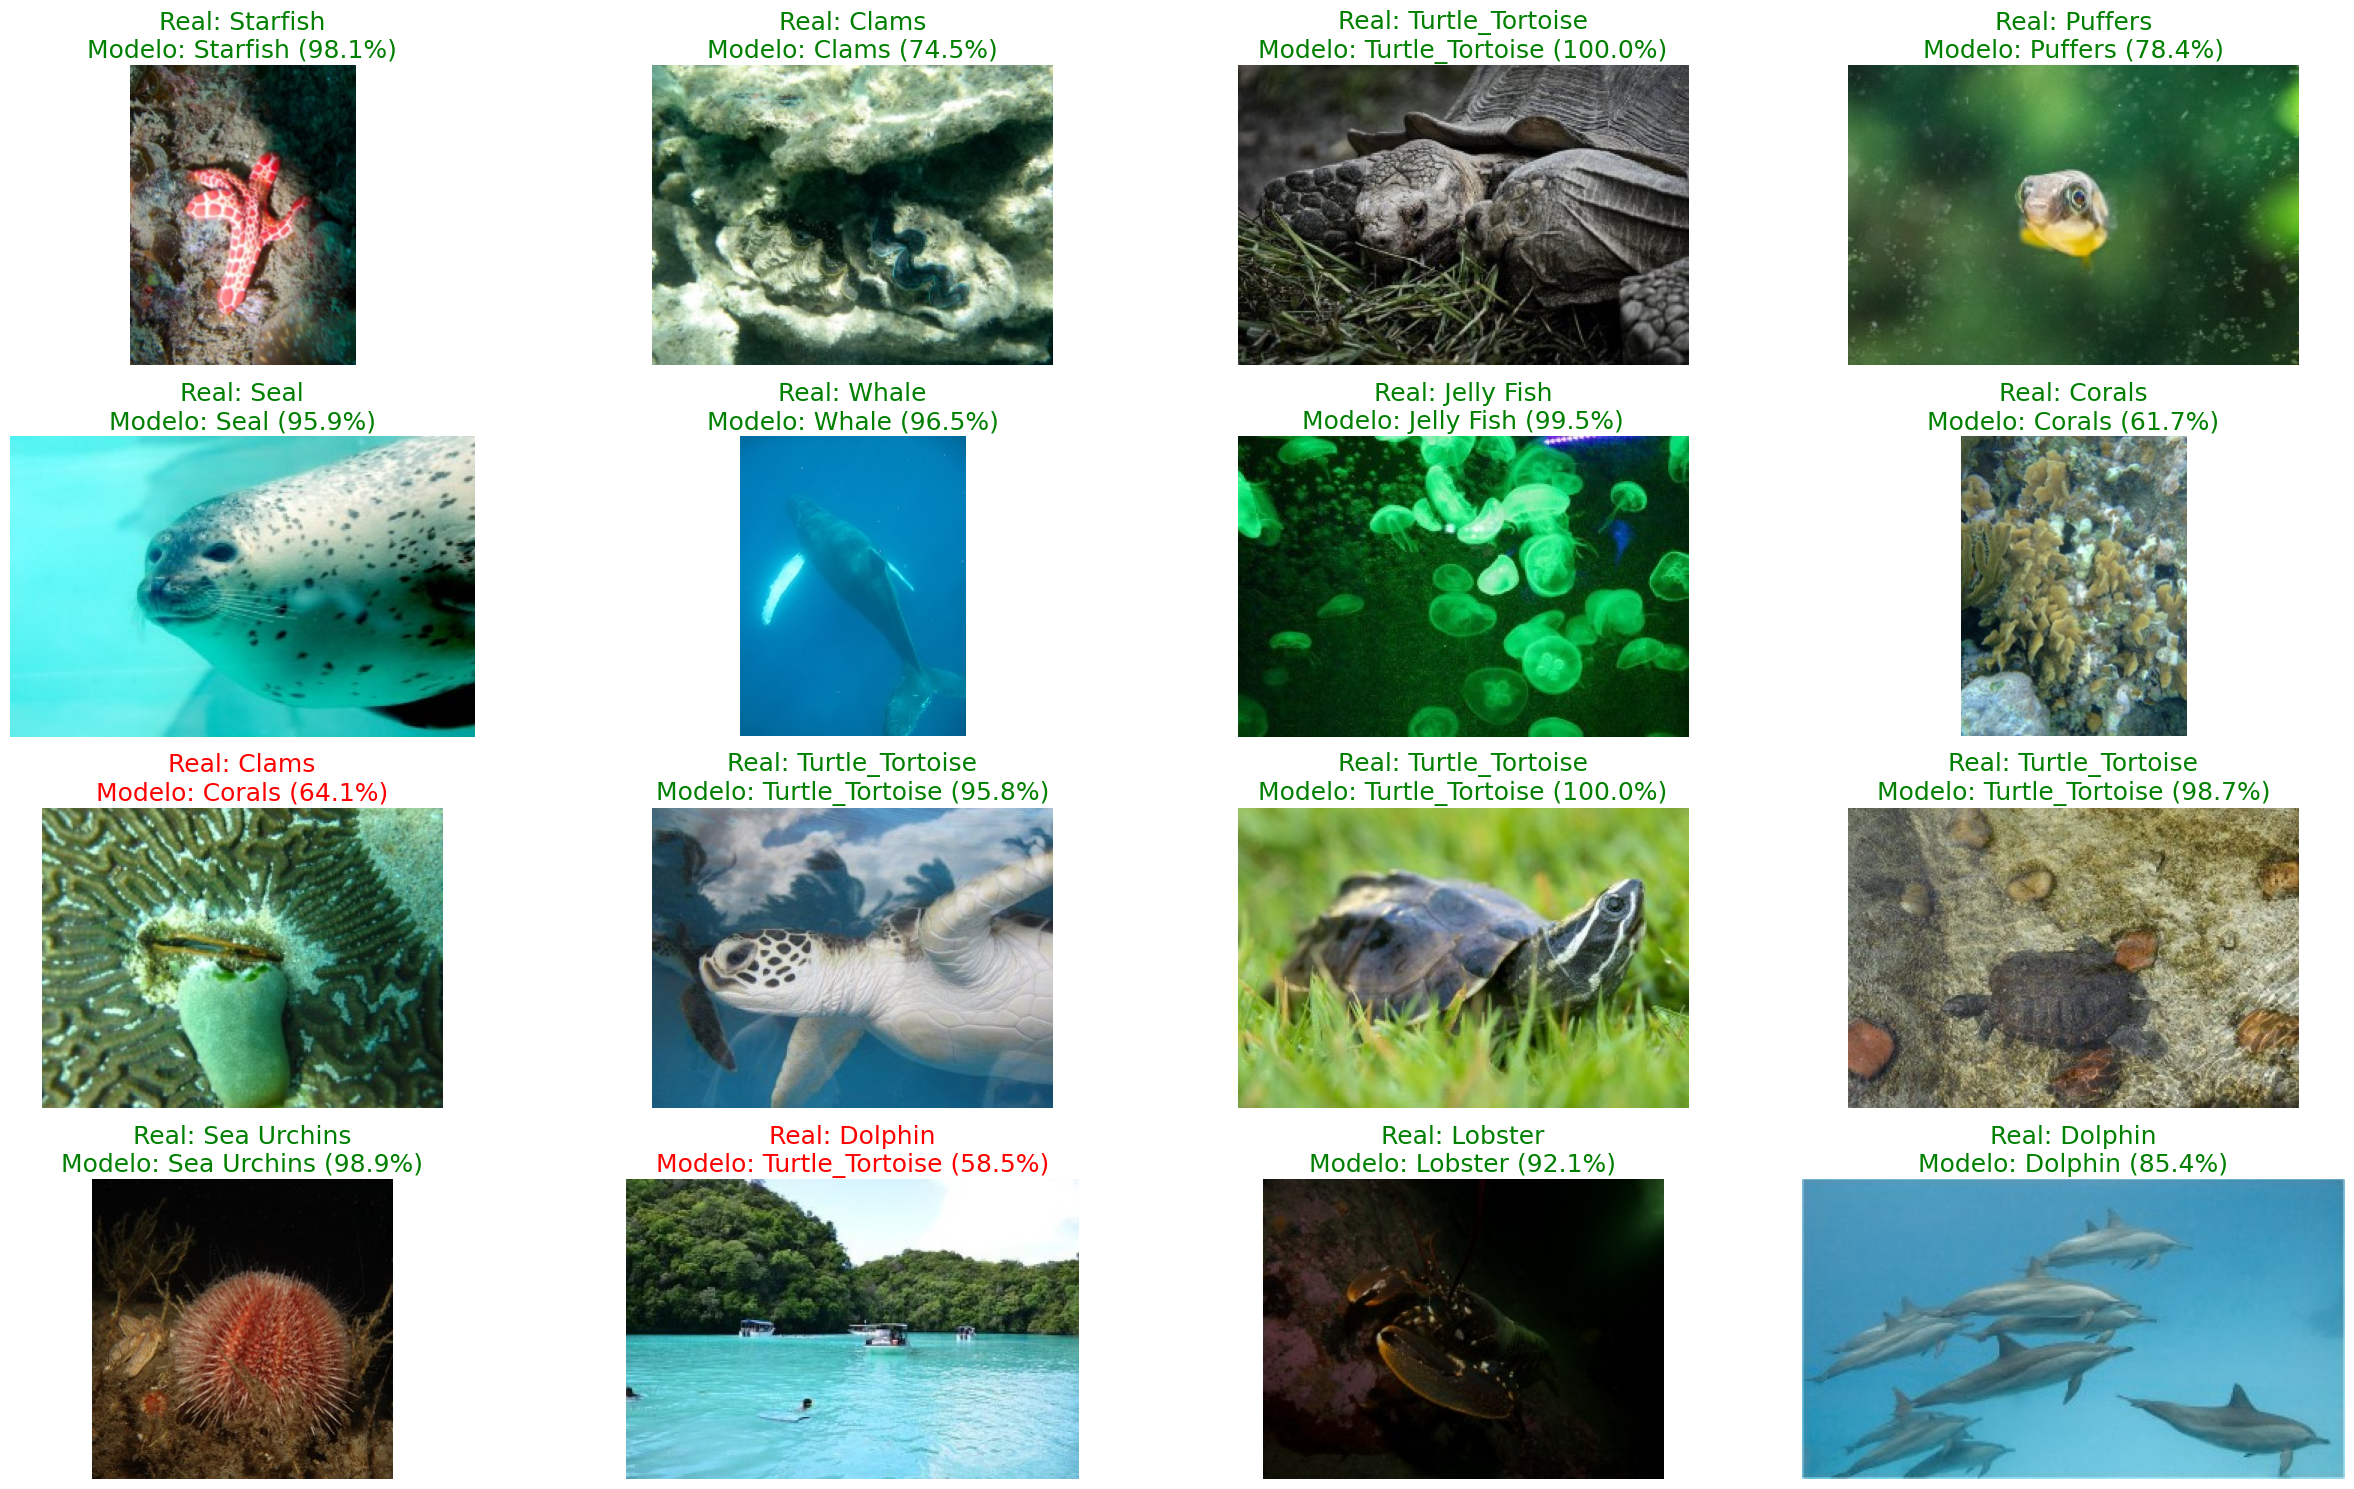

In [88]:
# Predict a batch of images
import matplotlib.axes

num_samples_to_test = 16
random_indexes = np.random.choice(total_predictions_count, size=num_samples_to_test, replace=False)


def visualize_test_predictions() -> None:
    ncols = 4
    nrows = num_samples_to_test // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 15), subplot_kw={"xticks": [], "yticks": []})
    axes: list[matplotlib.axes.Axes] = axs.flatten()
    for i, ax in enumerate(axes):
        random_prediction = prediction_results_df.iloc[random_indexes[i]]
        ax.imshow(plt.imread(random_prediction["Filepath"]))
        # ax.imshow(images_to_test[i].numpy().astype("uint8"))
        # ax.imshow(images_to_test[i].astype("uint8"))
        ax.set_axis_off()
        true_label_name: str = random_prediction["RealLabel"]
        predicted_label_name: str = random_prediction["PredictedLabel"]
        confidence: float = random_prediction["PredictionConfidence"] * 100
        title_color = "green" if predicted_label_name == true_label_name else "red"
        title = f"Real: {true_label_name}\nModelo: {predicted_label_name} ({confidence:.1f}%)"
        ax.set_title(title, color=title_color, fontsize=18)
    fig.tight_layout()
    plt.show()


visualize_test_predictions()

### Plotting the Classification Reports and Confusion Matrix

A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.

A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.

In [89]:
real_labels = list(prediction_results_df["RealLabel"])
predicted_labels = list(prediction_results_df["PredictedLabel"])
print(classification_report(real_labels, predicted_labels))

                 precision    recall  f1-score   support

          Clams       0.73      0.36      0.48       100
         Corals       0.49      0.73      0.58       100
          Crabs       0.98      0.99      0.99       100
        Dolphin       0.89      0.81      0.85       156
            Eel       0.84      0.80      0.82       100
           Fish       0.76      0.76      0.76        99
     Jelly Fish       0.95      0.98      0.96       169
        Lobster       0.92      0.76      0.83       100
    Nudibranchs       0.57      0.94      0.71       100
        Octopus       0.73      0.58      0.65       112
          Otter       0.96      1.00      0.98       100
        Penguin       0.97      0.91      0.94        96
        Puffers       0.95      0.87      0.91       106
       Sea Rays       0.85      0.89      0.87       104
    Sea Urchins       0.95      0.97      0.96       116
       Seahorse       0.87      0.72      0.79        96
           Seal       0.96    

In [90]:
report = classification_report(real_labels, predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Clams             0.734694  0.360000  0.483221   100.000000
Corals            0.486667  0.730000  0.584000   100.000000
Crabs             0.980198  0.990000  0.985075   100.000000
Dolphin           0.888112  0.814103  0.849498   156.000000
Eel               0.842105  0.800000  0.820513   100.000000
Fish              0.757576  0.757576  0.757576    99.000000
Jelly Fish        0.953757  0.976331  0.964912   169.000000
Lobster           0.915663  0.760000  0.830601   100.000000
Nudibranchs       0.569697  0.940000  0.709434   100.000000
Octopus           0.730337  0.580357  0.646766   112.000000
Otter             0.961538  1.000000  0.980392   100.000000
Penguin           0.966667  0.906250  0.935484    96.000000
Puffers           0.948454  0.867925  0.906404   106.000000
Sea Rays          0.853211  0.894231  0.873239   104.000000
Sea Urchins       0.949153  0.965517  0.957265   116.000000
Seahorse          0.873418  0.718750  0.788571    96.000000
Seal              0.958333  0.831325  0.890323    83.000000
Sharks            0.701987  0.898305  0.788104   118.000000
Shrimp            0.753623  0.530612  0.622754    98.000000
Squid             0.766355  0.854167  0.807882    96.000000
Starfish          0.960784  0.980000  0.970297   100.000000
Turtle_Tortoise   0.954082  0.984211  0.968912   380.000000
Whale             0.792453  0.736842  0.763636   114.000000
accuracy          0.841415  0.841415  0.841415     0.841415
macro avg         0.839081  0.820717  0.821081  2743.000000
weighted avg      0.853217  0.841415  0.839793  2743.000000

In [91]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 14), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


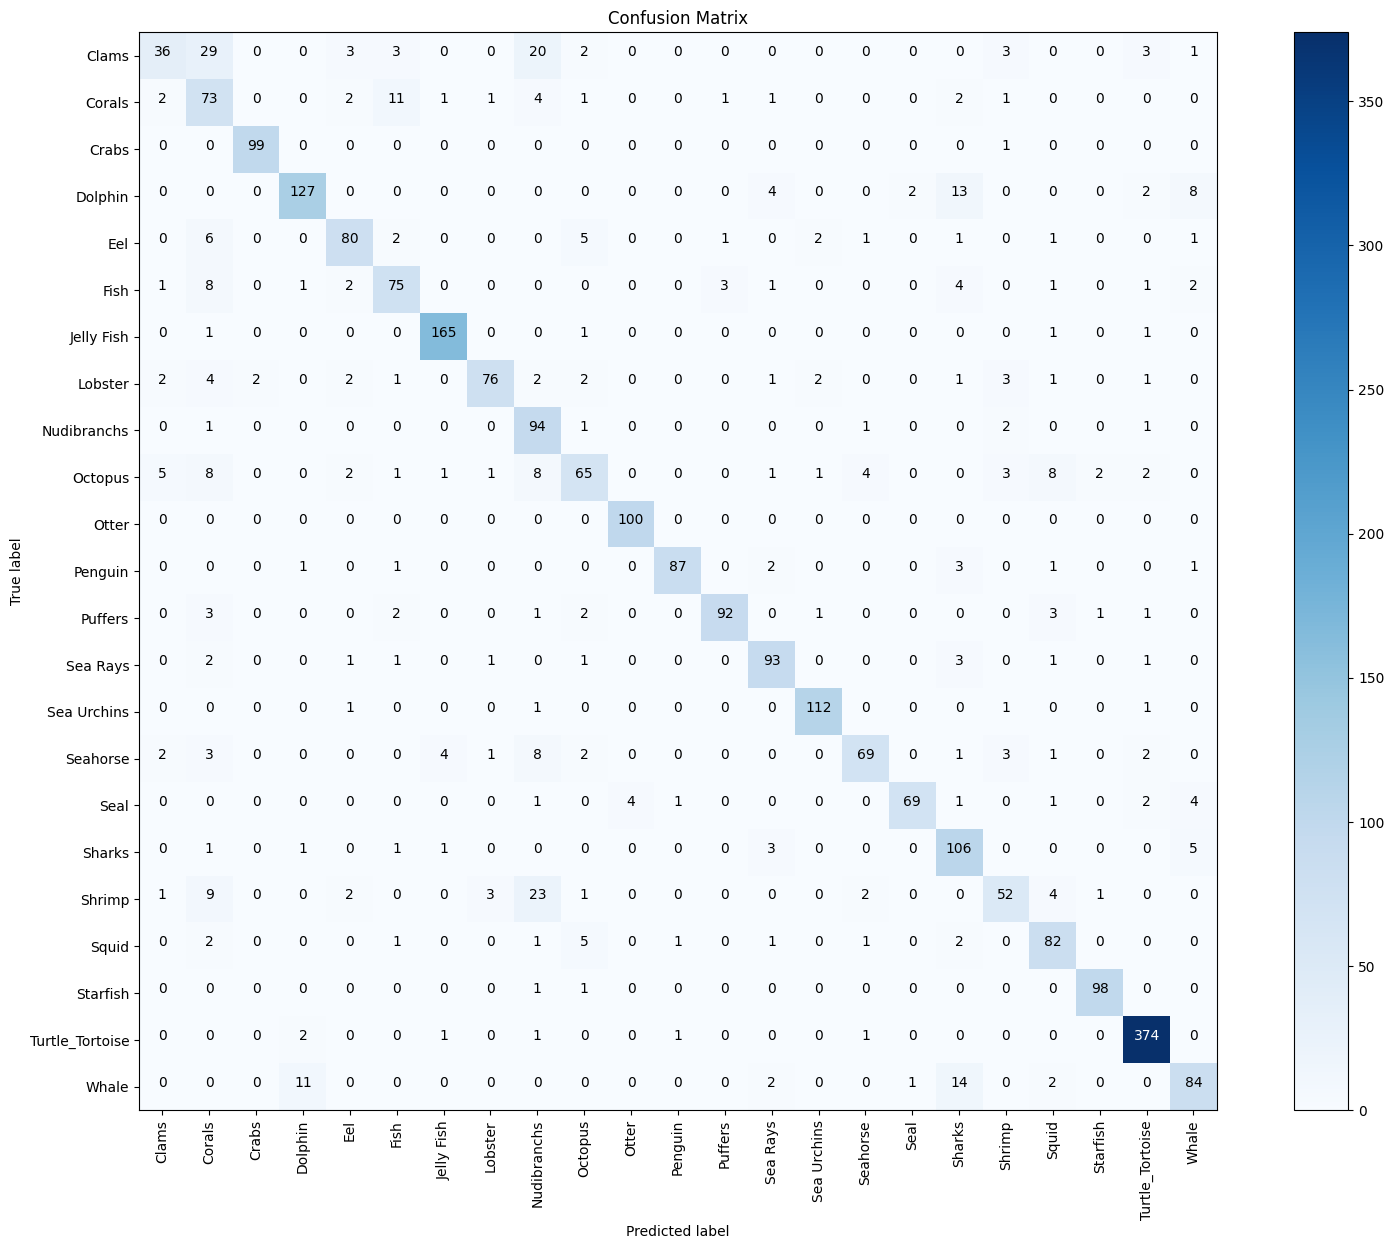

In [92]:
make_confusion_matrix(real_labels, predicted_labels, class_names)